## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.1]
redice_lr_patient = [5,10]

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.2830 - accuracy: 0.5547 - val_loss: 1.4983 - val_accuracy: 0.4739
Epoch 12/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.2586 - accuracy: 0.5630 - val_loss: 1.4819 - val_accuracy: 0.4787
Epoch 13/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.2317 - accuracy: 0.5723 - val_loss: 1.4740 - val_accuracy: 0.4801
Epoch 14/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.2078 - accuracy: 0.5830 - val_loss: 1.4829 - val_accuracy: 0.4828
Epoch 15/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.1861 - accuracy: 0.5911 - val_loss: 1.4724 - val_accuracy: 0.4781
Epoch 16/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.1620 - accuracy: 0.5992 - val_loss: 1.4717 - val_accuracy: 0.4778
Epoch 17/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.1402 - accuracy: 0.6069 - val_

batch_normalization_18 (Batc (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,742,474
Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 118us/step - loss: 2.6843 - accuracy: 0.1538 - val_loss: 2.2368 - val_accuracy: 0.1669
Epoch 2/25
50000/50000 [==============================] - 5s 105us/step - loss: 2.2451 - accuracy: 0.2539 - val_loss: 2.1478 - val_accuracy: 0.2291
Epoch 3/25
50000/50000 [==============================] - 5s 104us/step - loss: 2.0787 - accuracy: 0.2962 - val_loss: 2.0656 - val_accuracy: 0.2686
Epoch 4/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.9824 - accuracy: 0.3197 - val_loss: 1.9878 - val_accuracy: 0.2974
Epoch 5/25
500

50000/50000 [==============================] - 6s 113us/step - loss: 0.6560 - accuracy: 0.7779 - val_loss: 1.6051 - val_accuracy: 0.4940
Epoch 18/25
50000/50000 [==============================] - 6s 111us/step - loss: 0.6244 - accuracy: 0.7913 - val_loss: 1.7275 - val_accuracy: 0.4583

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 19/25
50000/50000 [==============================] - 6s 113us/step - loss: 0.5442 - accuracy: 0.8266 - val_loss: 1.5168 - val_accuracy: 0.5118
Epoch 20/25
50000/50000 [==============================] - 6s 110us/step - loss: 0.5033 - accuracy: 0.8445 - val_loss: 1.5457 - val_accuracy: 0.5093
Epoch 21/25
50000/50000 [==============================] - 6s 112us/step - loss: 0.4840 - accuracy: 0.8516 - val_loss: 1.5801 - val_accuracy: 0.5003
Epoch 22/25
50000/50000 [==============================] - 6s 112us/step - loss: 0.4609 - accuracy: 0.8608 - val_loss: 1.5771 - val_accuracy: 0.5084
Epoch 23/25
50000/50000 [============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.8486 - accuracy: 0.3680 - val_loss: 2.0711 - val_accuracy: 0.2503
Epoch 2/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.5280 - accuracy: 0.4644 - val_loss: 1.9214 - val_accuracy: 0.2830
Epoch 3/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.4304 - accuracy: 0.4996 - val_loss: 1.7074 - val_accuracy: 0.3986
Epoch 4/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.3621 - accuracy: 0.5242 - val_loss: 1.6119 - val_accuracy: 0.4298
Epoch 5/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.3073 - accuracy: 0.5456 - val_loss: 1.5976 - val_accuracy: 0.4270
Epoch 6/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.2576 - accuracy: 0.5635 - val_loss: 1.5021 - val_accuracy: 0.4685
Epoch 7/25
50000/50000 [==============================] - 6s 1

50000/50000 [==============================] - 6s 113us/step - loss: 2.0599 - accuracy: 0.3003 - val_loss: 2.0842 - val_accuracy: 0.3015
Epoch 20/25
50000/50000 [==============================] - 6s 113us/step - loss: 2.0492 - accuracy: 0.3029 - val_loss: 2.0760 - val_accuracy: 0.3038
Epoch 21/25
50000/50000 [==============================] - 6s 111us/step - loss: 2.0381 - accuracy: 0.3066 - val_loss: 2.0675 - val_accuracy: 0.3059
Epoch 22/25
50000/50000 [==============================] - 6s 112us/step - loss: 2.0284 - accuracy: 0.3089 - val_loss: 2.0591 - val_accuracy: 0.3086
Epoch 23/25
50000/50000 [==============================] - 6s 115us/step - loss: 2.0181 - accuracy: 0.3113 - val_loss: 2.0509 - val_accuracy: 0.3114
Epoch 24/25
50000/50000 [==============================] - 6s 114us/step - loss: 2.0089 - accuracy: 0.3142 - val_loss: 2.0427 - val_accuracy: 0.3134
Epoch 25/25
50000/50000 [==============================] - 6s 113us/step - loss: 2.0009 - accuracy: 0.3167 - val_loss:

50000/50000 [==============================] - 6s 112us/step - loss: 1.5984 - accuracy: 0.4426 - val_loss: 1.9261 - val_accuracy: 0.3067
Epoch 3/25
50000/50000 [==============================] - 5s 110us/step - loss: 1.4850 - accuracy: 0.4839 - val_loss: 1.7657 - val_accuracy: 0.3837
Epoch 4/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.4126 - accuracy: 0.5069 - val_loss: 1.6822 - val_accuracy: 0.4121
Epoch 5/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.3543 - accuracy: 0.5288 - val_loss: 1.6467 - val_accuracy: 0.4207
Epoch 6/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.3011 - accuracy: 0.5490 - val_loss: 1.5806 - val_accuracy: 0.4439
Epoch 7/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.2563 - accuracy: 0.5652 - val_loss: 1.8055 - val_accuracy: 0.3714
Epoch 8/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.2174 - accuracy: 0.5791 - val_loss: 1.658

50000/50000 [==============================] - 6s 111us/step - loss: 0.9464 - accuracy: 0.6841 - val_loss: 1.5049 - val_accuracy: 0.4845
Epoch 22/25
50000/50000 [==============================] - 6s 111us/step - loss: 0.9236 - accuracy: 0.6946 - val_loss: 1.5166 - val_accuracy: 0.4836
Epoch 23/25
50000/50000 [==============================] - 5s 109us/step - loss: 0.9017 - accuracy: 0.7035 - val_loss: 1.5967 - val_accuracy: 0.4587
Epoch 24/25
50000/50000 [==============================] - 6s 110us/step - loss: 0.8812 - accuracy: 0.7112 - val_loss: 1.5394 - val_accuracy: 0.4745
Epoch 25/25
50000/50000 [==============================] - 5s 109us/step - loss: 0.8618 - accuracy: 0.7180 - val_loss: 1.5378 - val_accuracy: 0.4846

Epoch 00025: ReduceLROnPlateau reducing learning rate to 6.250000296859071e-06.
Numbers of exp: 11, reduce_factor: 0.10, reduce_patient: 10
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape 

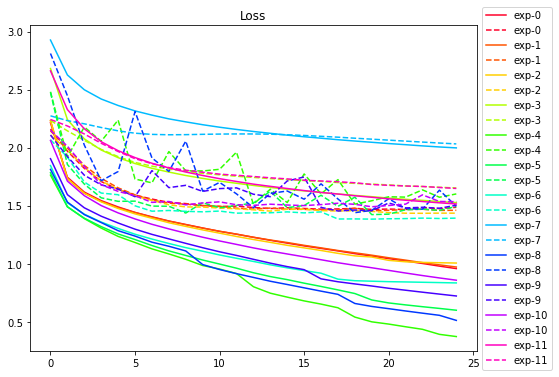

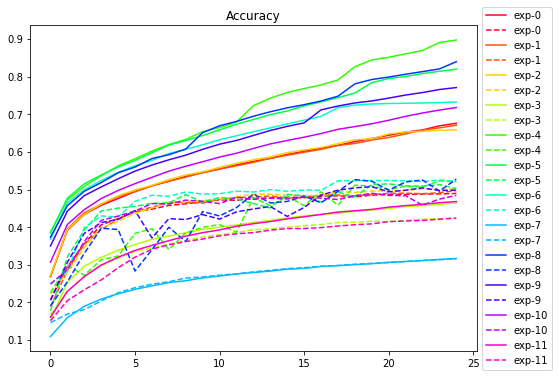

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()